# Can it even memorize? KENYA VCI DATA

In [15]:
%load_ext autoreload
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
    create_test_oxford_run_data
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [17]:
ds = pickle.load((base_dir / "data/kenya.pkl").open("rb"))
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    boku_VCI    (time, lat, lon) float64 43.72 31.13 85.88 20.18 ... nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.4688 0.4032 0.624 ... nan nan nan
    VCI         (time, lat, lon) float64 39.64 37.79 89.79 53.54 ... nan nan nan
    precip      (time, lat, lon) float64 13.66 18.42 24.78 47.38 ... nan nan nan
    E           (time, lat, lon) float64 52.86 64.59 64.59 75.49 ... nan nan nan
    Eb          (time, lat, lon) float64 2.3 2.311 2.311 2.409 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2993 0.3273 0.3273 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2837 0.309 0.309 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.121e-05 3.69e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.007123 -0.007165 ... nan nan
    sp          (time, lat, lon) float64 9.591e+04 9.604e+04 ... nan nan
    t2m         (time, lat, lon) float64 303.0 303.8 302.2 299.3 ... nan nan nan
    tp          (time, lat, lon) float64 0.0004198 0.0003483 ... nan nan

In [18]:
cfg = Config(base_dir / "configs/kenya.yml")
cfg._cfg["n_epochs"] = 3
cfg._cfg["autoregressive"] = True
cfg._cfg["horizon"] = 1
cfg._cfg["seq_length"] = 1
cfg._cfg["device"] = "cpu"
cfg._cfg["scheduler"] = "cycle"
cfg._cfg["input_variables"] = None
cfg._cfg["target_variable"] = "boku_VCI"
cfg._cfg["model"] = "bilstm"
cfg._cfg["num_workers"] = 1
cfg._cfg["constant_mean"] = None
cfg._cfg["constant_std"] = None
cfg._cfg["early_stopping"] = 1
cfg._cfg["encode_doys"] = True
cfg._cfg["static_inputs"] = "embedding"
cfg._cfg["hidden_size"] = 10
cfg._cfg["forecast_variables"] = ["precip", "t2m"]
cfg._cfg["batch_size"] = 30
cfg

{'autoregressive': True,
 'batch_size': 30,
 'constant_mean': None,
 'constant_std': None,
 'data_dir': PosixPath('data/kenya.pkl'),
 'device': 'cpu',
 'early_stopping': 1,
 'encode_doys': True,
 'experiment_name': 'kenya_static',
 'forecast_variables': ['precip', 't2m'],
 'hidden_size': 10,
 'horizon': 1,
 'input_variables': None,
 'learning_rate': 0.001,
 'loss': 'huber',
 'model': 'bilstm',
 'n_epochs': 3,
 'num_workers': 1,
 'optimizer': 'AdamW',
 'pixel_dims': ['lat', 'lon'],
 'run_dir': None,
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 1,
 'static_inputs': 'embedding',
 'target_variable': 'boku_VCI',
 'test_end_date': Timestamp('2020-12-31 00:00:00'),
 'test_start_date': Timestamp('2016-01-31 00:00:00'),
 'train_end_date': Timestamp('2015-12-31 00:00:00'),
 'train_start_date': Timestamp('2002-01-01 00:00:00'),
 'validation_end_date': Timestamp('2002-12-31 00:00:00'),
 'validation_start_date': Timestamp('2000-01-31 00:00:00')}

# create trainer

In [19]:
trainer = Trainer(cfg, ds)
tester = Tester(cfg, ds)

/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Loading Data:   1%|          | 16/1575 [00:00<00:10, 154.91it/s]

** Normalizer fit! **


Loading Data: 100%|██████████| 1575/1575 [00:03<00:00, 410.20it/s]


# Overfit on a single batch

In [20]:
train_batch = next(iter(trainer.train_dl))
test_batch = next(iter(tester.test_dl))

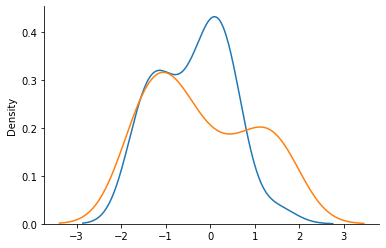

In [21]:
sns.kdeplot(train_batch["y"].numpy().flatten(), label="Train")
sns.kdeplot(test_batch["y"].numpy().flatten(), label="Test")
sns.despine()

In [22]:
model = trainer.model
optimizer = trainer.optimizer
loss_fn = trainer.loss_fn

In [23]:
trainer.train_dl.normalizer

In [24]:
# spatio_temporal.training.trainer.py:: Trainer._train_epoch & Trainer._validate_epoch
## TRAIN
N_EPOCHS = 50
epoch_losses = []
epoch_valid_losses = []

# initial mean_loss for the pbar.set_postfix_str 
y = train_batch["y"]
y_hat = model(train_batch)
mean_loss = loss_fn(y_hat["y_hat"], y)

for i in range(N_EPOCHS):
    pbar = tqdm(range(100), desc=f"Epoch {i}: ")
    pbar.set_postfix_str(f"{mean_loss.item():.2f}")
    train_loss = []
    for _ in pbar:
        
        #  zero gradient before forward pass
        optimizer.zero_grad()    

        # forward pass
        y_hat = model(train_batch)

        # measure loss on forecasts
        y = train_batch["y"]
        if not (y_hat["y_hat"].ndim == y.ndim):
            y = y.squeeze(0)
        loss = loss_fn(y_hat["y_hat"], y)

        # backward pass (get gradients, step optimizer, delete old gradients)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    mean_loss = np.mean(train_loss)
    
    ## VALIDATE
    valid_loss = []
    with torch.no_grad():
        # run forward pass
        y_val = test_batch["y"]
        y_hat_val = model(test_batch)
        val_loss = loss_fn(y_hat_val["y_hat"], y_val)
        valid_loss.append(val_loss.item())

    mean_valid_loss = np.mean(valid_loss)

    epoch_losses.append(mean_loss)
    epoch_valid_losses.append(mean_valid_loss)

Epoch 49: 100%|██████████| 100/100 [00:00<00:00, 285.91it/s, 0.18]


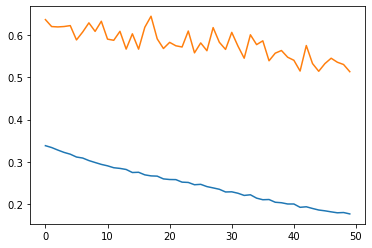

In [25]:
plt.plot(epoch_losses)
plt.plot(epoch_valid_losses)